# ConfWorks demo
### [![GitHub](https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/moldagulovg/confWorks) This demonstration notebook shows basic usage of confWorks python-wrapper.


### [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moldagulovg/confWorks/blob/main/demo.ipynb) You may open this .ipynb notebook in Google Collab


## 0. Setup  

### 0.1 Install required packages

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install() # expect a kernel restart

✨🍰✨ Everything looks OK!


In [2]:
! mamba install xtb


Looking for: ['xtb']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  conda-forge/linux-64                                          No change
[+] 0.2s
conda-forge/noarch   1%[+] 0.3s
conda-forge/noarch   4%[+] 0.4s
conda-forge/noarch  13%[+] 0.5s
conda-forge/noarch  24%[+] 0.6s
conda-forge/noarch  26%[+] 0.7s
conda-forge/noarch  36%[+] 0.8s
conda-forge/noarch  45%[+] 0.9s
conda-forge/noarch  61%[+] 1.0s
conda-forge/noarch  67%[+] 1.1s
conda-forge/noarch  76%[+] 1.2s
conda-forge/noarch  87%[+] 1.3s
conda-forge/noarch  96%[+] 1.4s
conda-forge/noarch 100%[+] 1.5s
conda-forge/noarch 100%[+] 1.6s
conda-forge/noarch 100%conda-forge/noarch                                

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [1]:
! xtb --version

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

normal termination of xtb


In [4]:
! pip install git+https://github.com/moldagulovg/confWorks.git

  Cloning https://github.com/moldagulovg/confWorks.git to /tmp/pip-req-build-76sa8z7t
  Running command git clone --filter=blob:none --quiet https://github.com/moldagulovg/confWorks.git /tmp/pip-req-build-76sa8z7t
  Resolved https://github.com/moldagulovg/confWorks.git to commit be93b2025a3285c6338390827956357ae56d62cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### 0.2. Import packages

In [1]:
import os
import shutil
import subprocess
import time

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
print(rdkit.__version__)
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol

import confworks
from confworks.util import calc_rmsd_single_mol
from confworks.util import optimize_molecule, xtb_SP, conformer_search

2022.09.5


## 1. xTB Single Point Calculation

### 1.1. Define a molecule here

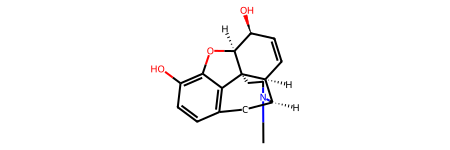

In [2]:
mol = Chem.MolFromSmiles('CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O')
display(mol)

### 1.2 Embed 3D conformers for mol using RDKit's ETKDGv3 method

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

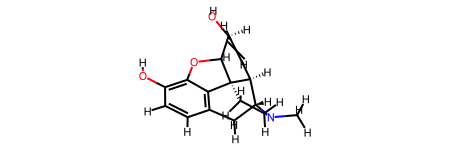

In [3]:
mol = Chem.AddHs(mol)
AllChem.EmbedMultipleConfs(mol, 10)
display(mol)

### 1.3 Single point calculation  via *xtb_SP*
We can calculate single point energies for each conformer in a molecule using *xtb_SP* function. You may supply xtb arguments (e.g. basis function, optimization level, charge, number of unpaired electrons, solvent, etc. via keywords)

In [4]:
mol = xtb_SP(mol, gfn_xtb=2)

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


In [5]:
energies = []
for conf in mol.GetConformers():
    energy = conf.GetDoubleProp('conf_energy')
    energies.append(energy)
print(energies)
print(f'min E: {min(energies)}')


[-61.183325991776, -61.20294925917, -61.183217449087, -61.175883982405, -61.176003204838, -61.194058292155, -61.186170296585, -61.190457740108, -61.190119757365, -61.172445566079]
min E: -61.20294925917


## 2. Geometry optimization
The *optimize_molecule* function will start geometry optimization for every conformer in the original input mol. You may also specify conformer ID for a single optimizatoin. As a result atom coordinates and energies are updated for each conformer.You may add geometry optimization arguments via function keywords.

In [6]:
mol_opt = optimize_molecule(mol, gfn_xtb=2)

x


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

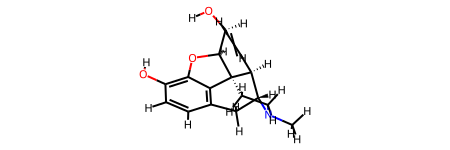

In [7]:
display(mol_opt)

In [8]:
energies = []
for conf in mol_opt.GetConformers():
    energy = conf.GetDoubleProp('conf_energy')
    energies.append(energy)
print(energies)
print(f'min E: {min(energies)}')

[-61.241826105113, -61.247496256679, -61.239395898259, -61.235240802953, -61.239365534744, -61.241810031618, -61.239401461689, -61.235231652856, -61.239340844085, -61.239372571022]
min E: -61.247496256679


In [9]:
print(-61.195817638543 - (-61.24428961909))

0.048471980546999305


## 3. Conformer sampling

In [10]:
mol_list_crest = conformer_search(mol_opt, gfn_xtb=2)

  0%|          | 0/10 [25:29<?, ?it/s]


KeyboardInterrupt: 